In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
#import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

1. Разбивка пользователей на группы: генерация соли, создание функции для разбивки пользователей
2. Бутстрэп и доверительные интервалы
3. Дизайн теста: MDE 

# Разбивка пользователей на группы

https://www.kaggle.com/code/danielxing/product-metrics-evaluation-and-consumer-clustering/input датасет про магазин


In [33]:
shop_df = pd.read_csv('2019-Dec.csv') # датафрейм из ссылки выше (его же можно использовать для ДЗ)

In [34]:
shop_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


У нас есть пользовательские логи. Допустим, мы хотим провести дизайн теста на этих данных. 
Необходимо разбить пользователей на группы

1. Проверяем тип данных в колонке, по которой будем разбивать
2. Выбираем хэш-функцию, соль и создаем новую колонку хэшированного айди
3. Конвертируем в числовой вид и берем остаток от целочисленного деления на 2. По остатку выставляем группу

https://python.readthedocs.io/en/stable/library/hashlib.html 

In [9]:
shop_df['hash'] = ((shop_df['user_id'].astype(str)) + '#' + '20231503').apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

shop_df['group'] = ((shop_df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

In [10]:
shop_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hash,group
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,bc3234a183421070fde345b1e67126c5ef667cdf2e9cff...,B
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,660c995df50f87ff9c4c6e68d8b7498e74a471af046263...,A
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2a4a58a229bea1e05fd0364e3c660ae238a367bc8e465a...,B
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,5d49d0c5d0bdbdd850ec7546a1ee5f8eca630276bc6b3e...,A
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,84079b35ca87e5c2700c10b027eec0b0fb9d2f364b200e...,A


In [11]:
shop_df.groupby(['group']).count()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hash
group,,,,,,,,,,
A,1755829,1755829,1755829,1755829,28902,1003132,1755829,1755829,1755456,1755829
B,1777457,1777457,1777457,1777457,29563,1019865,1777457,1777457,1777051,1777457


In [12]:
shop_df.groupby(['group']).nunique()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hash
group,,,,,,,,,,
A,1098948,4,41588,473,10,249,2051,184831,421317,184831
B,1105081,4,41690,468,10,250,2062,185323,418519,185323


In [13]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

# '''os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use 
#    or we can say this method generates a string containing random characters.'''
# https://www.geeksforgeeks.org/python-os-urandom-method/ 

In [14]:
def groups_splitter(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

Проверим, как функция работает

In [42]:
shop_df = shop_df.drop(columns=['hash', 'group']) # дропаем колонки, если они остались от предыдущих упражнений

In [43]:
shop_df.head(3) # проверяем, все ли окей

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554


In [44]:
groups = groups_splitter(shop_df.copy()) # передаем копию датафрейма, чтобы исходный не менялся
shop_df = pd.merge(shop_df, groups, how='left', on=['user_id']) # джойним датафрейм с логами с датафреймом юзер-группа

In [45]:
shop_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,group
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,B
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,A
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,A
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,A
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,B


# Дизайн АВ-теста: формула MDE и бутстрэп

Вспомним, как выглядит формула MDE:

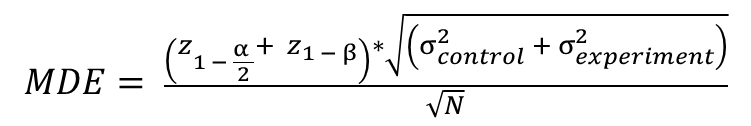

Как вычислить квантили нормального распределения?

Таблицы со значениями можно посмотреть здесь:
https://studfile.net/preview/3795082/page:2/ 

In [21]:
from scipy.stats import norm

In [22]:
norm.ppf(1-(0.05 / 2), loc=0, scale=1)

1.959963984540054

In [23]:
norm.ppf(1-0.2, loc=0, scale=1)

0.8416212335729143

Теперь можем написать функцию:

In [24]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1-(alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1-beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

Опробуем на сгенерированной поюзерной метрике

In [47]:
shop_df_users = shop_df[['user_id', 'group']].drop_duplicates()
shop_df_users['metric'] = np.random.randint(100, size=shop_df_users.shape[0])

In [48]:
shop_df_users.head()

,user_id,group,metric
0,576802932,B,19
1,412120092,A,42
2,494077766,A,65
3,348405118,A,17
4,576005683,B,86


In [28]:
get_mde(shop_df_users['metric'], alpha=0.05, beta=0.2)

0.2685347948065585

In [29]:
get_mde(shop_df_users['metric'], alpha=0.005, beta=0.2)

0.3497272957913368

Но можно дизайн делать на бутстрэпе:

# Бутстрэп и доверительные интервалы

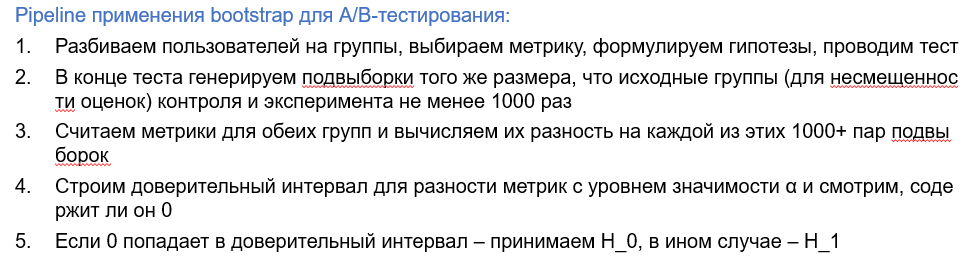

Попробуем применить данную механику для дизайна, оценив корректность теста

Нам понадобятся следующие функции:

In [30]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [77]:
correctness = []

for i in tqdm(range(1000)):
    
    new_group = groups_splitter(shop_df_users.copy(), salt=salt_generator())
    new_df = pd.merge(shop_df_users, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')]['metric']
    vec_b = new_df[(new_df['group'] == 'B')]['metric']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'correctness: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|██████████| 1000/1000 [2:15:07<00:00,  8.11s/it] 

correctness: 4.6%


In [50]:
shop_df_users = shop_df_users.drop(columns=['group']) # дропаем колонку с группами, оставшуюся от предыдущих упражнений

In [51]:
correctness = []

for i in tqdm(range(10)): # 10 итераций - мало, так не делаем, пример иллюстративный
    
    new_group = groups_splitter(shop_df_users.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop_df_users, new_group, how="left", on=['user_id']).drop_duplicates()
    
    vec_a = new_df[(new_df['group'] == 'A')]['metric']
    vec_b = new_df[(new_df['group'] == 'B')]['metric']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'correctness: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%', test_correctness[1], test_correctness[0], test_correctness)

100%|██████████| 10/10 [01:27<00:00,  8.72s/it]

correctness: 20.0% 2 8 Counter({False: 8, True: 2})


Результаты выше наглядно демонстрируют, почему 10 итераций - мало. 

На 1000 результат < 5% (что хорошо, в ошибку укладываемся), на 10 - 20%

# ДЗ 2:

1. Дизайн: написать функцию для вычисления длительности теста. Проиллюстрировать применение на сгенерированных данных


2. Разбивка пользователей: написать функцию разбивки пользователей на а) 2 группы неравного размера (не 50/50), б) 30 групп равного размера


3. Бутстрэп + дизайн: 

- а) сгенерировать выборки без выбросов, докинуть эффект на одну из них равномерно и с помощью распределения (нормальное и любое другое на выбор)
- б) то же, что и в а), но выборки с выбросами сделать
- в) для случаев из а) и б) бутстрэпом оценить: среднее, медиану, 25% перцентиль, построить доверительные интервалы для статистик (речь о разницах средних/медиан/перцентилей для групп)
- г) для случаев из а) и б) оценить среднее т-тестом и Манном-Уитни. Сравнить с результатами бутстрэпа. Сделать выводы. Сравниваем точечные оценки (на бутстрэпе их тоже считаем)

СОВЕТ: Т.к бутстрэп считается долго, то для дз отлаживаем код на малом количестве итераций, а результаты уже показываем на 1000+